# CS590 Data Science Sp21
# In-class Competition: Stress Prediction

### Author: Jun Zhuang

## README

### 0. About The Project
In this competition, I employ several machine learning models to predict the stress level based on the survey data. The prediction is evaluated by RMSE (The smaller, the better).


### 1. Dataset
The dataset comes from Kaggle competition: <https://www.kaggle.com/c/stress-prediction/data>


### 2. Preprocessing
* **Features Selection**  
At first, I employ the backward/forward selection with a given threshold (**ts**) that filters out the columns whose non-null value is lower than the given threshold. The result shows that using **ts=0.86** can maintain most features (filter one out) and achieves the best score in the leaderboard.  
I also implement **Sparse Regression** to find out the top 10 important features by using glmnet. These features are *'hisp', 'hincome', 'fam_exp1_cv', 'fam_actions_cv_10', 'fam_discord_cv', 'child_social_media_time_cv', 'physical_activities_hr_cv', 'sitting_weekday_hour_cv', 'SEX_F', 'SEX_M'*. The result shows that the family discord caused by COVID-19, the time that child spends on social media per week, and female has a strong positive relationship with the stress, whereas the physical activities per week and house income are negative to the stress. I'm wondering whether or not female is easier to feel stressed when they realize that their children spend so much time on social media (father doesn't seem to care about this). On the other hand, physical activities help release stress. According to this information, I select these ten features to predict but unfortunately got a bad RMSE (**2.8197**) in local data. Thus, I decide not to submit this prediction.

* **Fill the Null Values**  
I fill the null values of selected columns with three methods: **mean, mode, and class-mean**. For the first two methods, I fill the null values by the mean/mode value of the current column. For the third method, I find out the mean value of each class and then fill the null values with their corresponding mean. The result shows that the third method suffers serious overfitting problems. The first method achieves the best performance and thus I use this method in the competition.

* **Implement One-hot Embedding**  
I implement one-hot embedding on *'SEX' and 'higheduc'* as these two features are categorical strings. 

* **Drop Unnecessary Columns**  
After that, I drop some unnecessary columns such as *'ID', 'interview_date', 'pstr', 'train_id' or 'test_id'*.

* **Normalization**  
Lastly, I normalize all values within [0, 1]. I repeat the above-mentioned preprocessing procedure for both train data and test data.


### 3. Methods
In this competition, I attempt several base models as follows:  
1. Generalized linear model (glm);
2. Generalized boosted regression model (gbm);
3. Random forest (rf);
4. Support vector regression (svr);
5. XGBoost (xgb);
6. Ligthgbm (lgb);
7. Neural Networks (cnn).


* At first, I try glm, gbm, rf, and svr. For svr, I try the kernel with 'linear', 'poly', and 'rbf'. The '**poly**' kernel has better performance so that I use this kernel for svr in this competition. The result shows that the gradient boosting method (**gbm**) achieved better performance (lower RMSE). Thus, I decided to go in this direction and try xgb and lgb.  
* For xgb and lgb, I apply **grid search** to find out the optimal parameters (presented in the script). The submission reveals that using lgb with **85 features** (fill nan by mean) achieves the best performance (**RMSE=2.74570**) so far.  
* In the next step, I try two ensemble methods to boost the performance. At first, I use "**stacking**" method by stacking the top-3-performance model's predicted labels (lgb, svr, xgb) and then apply linear regression to generate the final prediction. This result (**RMSE=2.76409**) is worse than the previous one.  
* Furthermore, I also propose a new ensemble method, **iterative averaging (IA)**, to achieve better performance in the public leaderboard. This method averages the top-n predicted labels at first and then iteratively replaces the worst one if the new generated label achieves better performance. The process repeats until the generated label converges. **The intuition is that the prediction from different base models may be close to the optimum. Iterative averaging of the top-n predictions helps approach the optimum better.** In this competition, I use the **top 3** predictions in this method and achieve the best ***RMSE=2.74244*** in the public leaderboard. The pseudocode is presended below:  
```python
def iterative_averaging(Top_n_pred, Y_gt):
    """
    @topic: Ensemble method: iterative averaging (IA).
    @input: 
        Top_n_pred (mxn): the list of predicted labels;
        Y_gt (mx1): the ground truth label.
    @return:
        Y_pred_mean (mx1): the new predicted label.
    """
    Y_pred_mean = mean(Top_n_pred) # Averages the top-n predicted labels
    while gap > 1e-4:
        # If the new generated label achieves better performance
        if RMSE(Y_pred_mean) < RMSE(Top_n_pred).any(): 
            Top_n_pred.replace(Y_pred_mean) # Replaces the worst one
            Y_pred_mean_new = mean(Top_n_pred) # New prediction
            gap = RMSE(Y_pred_mean_new) - RMSE(Y_pred_mean)
            Y_pred_mean = Y_pred_mean_new # Update the prediction
     return Y_pred_mean
```

* Besides, I also employ cnn in this task. The RMSE without dropout is **12.4962** on the test set whereas using dropout=0.3 improves the RMSE to **2.9544**. Note that both results are good on the train/validation set but the RMSE gets worse on the test without dropout. This result indicates using dropout can largely mitigate the overfitting. However, RMSE=2.9544 is not good so that I decide not to consider CNN.


### 4. Conclusion
In this competition, I implement Sparse Regression to find out the important features related to the stress level and investigate several base machine learning models. Moreover, I propose a new ensemble method, **iterative averaging (IA)**, to achieve better performance in the public leaderboard.


### Acknowledgments
 Thanks professor Mohler for his insightful suggestions.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
# Import dataset
data_df1 = pd.read_csv('./data/train.csv')
data_df2 = pd.read_csv('./data/test.csv')
#print("train.csv: \n")
#print(data_df1.info()) # 查看特征统计
#print(data_df1.describe()) # 查看数据的描述性统计
#data_df1.corr() # 展示变量之间的相关性
#data_df1.head() # 查看数据前5行
#print("test.csv: \n")
#print(data_df2.info())
#print(data_df2.describe())


## Preprocessing

In [3]:
# Extract the label and id
label = data_df1["pstr"]
#print("Classes distribution: \n", label.value_counts())
#print("Exist null labels? Ans:", label.isnull().any())
#train_id = data_df1["train_id"]
test_id = data_df2["test_id"]


In [4]:
# Utils functions for preprocessing

def select_cols_fillna(df, ts):
    # Select the columns from dataframe (df) that the percentage of null values is lower than given threshold (ts), 
    # and fill the nan with the mode/mean of corresponding columns.
    df = df.copy()
    list_drop = []
    for column in df.columns:
        if df[column].isnull().sum()/len(df) < ts:
            if df[column].dtypes == 'float64':
                df[column].fillna(df[column].mean(), inplace=True) # fill the nan with column mean
            else:
                df[column].fillna(df[column].mode()[0], inplace=True) # fill the nan with column mode
        else:
            list_drop.append(column)
    return df, list_drop

def select_cols_fillna_train(df, ts, label_col="pstr", idx_col="train_id"):
    # Select the columns from dataframe (df) that the percentage of null values is lower than given threshold (ts), 
    # and fill the nan with the mean of corresponding class in this columns.
    # ref: https://blog.csdn.net/u010383605/article/details/78879515
    df = df.copy() 
    df.index = list(data_df1[idx_col]) # assign the index for dataframe
    list_drop = []
    for column in df.columns:
        if df[column].isnull().sum()/len(df) < ts:
            if df[column].dtypes == 'float64':
                df_temp = df[[label_col, column]].groupby(label_col).mean() # 当前类别的均值表
                na_ttable = df[column].isna() # true table of nan
                na_label = list(df.loc[na_ttable, label_col]) # the label of nan
                na_cm = df_temp.loc[na_label, column] # 依据上述标签，取均值表里对应的值(class mean)
                na_cm.index = df.loc[na_ttable, column].index # change the index
                df.loc[na_ttable, column] = na_cm
                if df[column].isnull().sum() > 0: # check the nan value again
                    df[column].fillna(df[column].mean(), inplace=True) # fill the nan with column mean
            else:
                df[column].fillna(df[column].mode()[0], inplace=True) # fill the nan with column mode
        else:
            list_drop.append(column)
    return df, list_drop

def ohe_cols(df, list_ohe):
    # Implement one-hot embedding on selected columns
    df = df.copy()
    for column in list_ohe:
        tmp_col = pd.get_dummies(df[column], prefix=column) # generate one-hot embedding
        df = pd.concat([df, tmp_col], axis=1) # concate the new ohe to original df
        df.drop([column], axis=1, inplace=True)
    return df

def drop_cols(df, list_drop):
    # Drop selected colums (list_drop) and return the new daraframe (df)
    df = df.copy()
    for column in df.columns:
        if column in list_drop:
            df.drop([column], axis=1, inplace=True)
    return df

def normalize(df):
    # Normalize the dataframe to [0,1].
    for column in df.columns:
        max_value = df[column].max()
        min_value = df[column].min()
        df[column] = (df[column] - min_value) / (max_value - min_value)
    return df


In [5]:
## Preprocessing for "train.csv"

# 1. Fill nan value
ts = 0.86 # 0.99/0.86/0.78/0.76/0.75
df_fillna1, list_drop = select_cols_fillna(data_df1, ts)
# The preproceesing below causes overfitting (abandon)
#df_fillna1, list_drop = select_cols_fillna_train(data_df1, ts, label_col="pstr", idx_col="train_id")
#print("Drop list: \n", list_drop)
# 2. One-hot embedding
list_ohe = ["SEX", "higheduc"]
df_ohe1 = ohe_cols(df_fillna1, list_ohe)
# 3. Drop selected columns
list_drop2 = ["ID", "interview_date", "pstr", "train_id"]
list_drop.extend(list_drop2)
df_drop1 = drop_cols(df_ohe1, list_drop)
# 4. Normalize the df to [0, 1]
df_nm1 = normalize(df_drop1)
#print(df_nm1.info())
df_nm1


,interview_age,ageyear,pamarriedliving,race4,race6,hisp,raceeth5,raceeth7,hincome,pamarital,...,walking_hour_per_day_2_cv,walking_hour_per_day_cv,walking_min_per_day_cv,SEX_F,SEX_M,higheduc_< HS Diploma,higheduc_Bachelor,higheduc_HS Diploma/GED,higheduc_Post Graduate Degree,higheduc_Some College
0,0.76,0.75,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.158926,0.065736,0.476275,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.64,0.50,1.000000,0.333333,0.200000,0.0,0.250000,0.200000,0.636816,1.000000,...,0.158926,0.065736,0.476275,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.66,0.50,1.000000,0.333333,0.200000,0.0,0.250000,0.200000,0.636816,1.000000,...,0.158926,0.065736,0.476275,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.68,0.50,1.000000,0.333333,0.200000,0.0,0.250000,0.200000,0.636816,1.000000,...,0.158926,0.065736,0.476275,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.08,0.00,0.804614,0.217457,0.188341,0.0,0.235401,0.208682,0.000000,0.759063,...,0.158926,0.065736,0.476275,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517,0.58,0.50,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,...,0.312500,0.065736,0.476275,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8518,0.84,0.75,1.000000,0.333333,0.200000,0.0,0.250000,0.200000,1.000000,1.000000,...,0.158926,0.065736,0.476275,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8519,0.44,0.25,1.000000,0.000000,0.000000,1.0,0.500000,0.400000,0.000000,1.000000,...,0.158926,0.130435,0.750000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8520,0.46,0.50,1.000000,0.000000,0.000000,1.0,0.500000,0.400000,0.000000,1.000000,...,0.158926,0.043478,0.750000,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
# Preprocessing for "test.csv"

# 1. Fill nan value
ts = 0.86 # 0.99/0.86/0.78/0.76/0.75
df_fillna2, list_drop = select_cols_fillna(data_df2, ts)
#print("Drop list: \n", list_drop)
# 2. One-hot embedding
list_ohe = ["SEX", "higheduc"]
df_ohe2 = ohe_cols(df_fillna2, list_ohe)
# 3. Drop selected columns
list_drop2 = ["ID", "interview_date", "test_id"]
list_drop.extend(list_drop2)
df_drop2 = drop_cols(df_ohe2, list_drop)
# 4. Normalize the df to [0, 1]
df_nm2 = normalize(df_drop2)
df_nm2


,interview_age,ageyear,pamarriedliving,race4,race6,hisp,raceeth5,raceeth7,hincome,pamarital,...,walking_hour_per_day_2_cv,walking_hour_per_day_cv,walking_min_per_day_cv,SEX_F,SEX_M,higheduc_< HS Diploma,higheduc_Bachelor,higheduc_HS Diploma/GED,higheduc_Post Graduate Degree,higheduc_Some College
0,0.46,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,...,0.156959,0.086957,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.48,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,...,0.156959,0.086957,0.473421,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.50,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,...,0.375000,0.064729,0.473421,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.16,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.156959,0.130435,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.18,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.156959,0.043478,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8347,0.84,0.75,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.156959,0.043478,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8348,0.86,0.75,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.156959,0.043478,0.750000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8349,0.88,0.75,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.125000,0.064729,0.473421,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8350,0.28,0.25,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.156959,0.217391,0.750000,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Examine classic regression models

In [7]:
# Models
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Generalized linear model (glm)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
def GLM(X_train, Y_train):
    """
    @topic: Fitting the generalized linear model
    @input: X_train/Y_train: train data/label (array)
    @return: model: trained gl model
    """
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    return model

# Generalized boosted regression model (gbrm)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
def GBRM(X_train, Y_train):
    """
    @topic: Fitting the generalized boosted regression model
    @input: X_train/Y_train: train data/label (array)
    @return: model: trained gbr model
    """
    model = GradientBoostingRegressor(random_state=0)
    model.fit(X_train, Y_train)
    return model

# Random forest regressor (rfr)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
def RFR(X_train, Y_train):
    """
    @topic: Fitting the random forest regressor
    @input: X_train/Y_train: train data/label (array)
    @return: model: trained rfr
    """
    model = RandomForestRegressor(max_depth=2, random_state=0) # max_depth: the maximum depth of the tree
    model.fit(X_train, Y_train)
    return model

# SVM regression model (svrm)
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html
def SVRM(X_train, Y_train):
    """
    @topic: Fitting the SVM regression model
    @input: X_train/Y_train: train data/label (array)
    @return: model: trained svr model
    """
    #model = SVR(kernel='rbf', C=1.0, gamma=0.1, epsilon=.1)
    #model = SVR(kernel='linear', C=1.0, gamma='auto')
    model = SVR(kernel='poly', C=1.0, gamma='auto', degree=3, epsilon=.1, coef0=1)
    model.fit(X_train, Y_train)
    return model


### Implement 2-Folds on train.csv for cross-validation

In [8]:
# Implement 2-Folds on train.csv for cross-validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
def KFolds(data, label, K=2):
    # Split dataset (np.array) and label (np.array) into K folds (int)
    assert len(data) == len(label)
    kf = KFold(n_splits=K, random_state=0, shuffle=True)
    for train_idx, test_idx in kf.split(data):
        #print("TRAIN:", train_idx, "TEST:", test_idx)
        X_train, X_test = data[train_idx], data[test_idx]
        Y_train, Y_test = label[train_idx], label[test_idx]
    return X_train, Y_train, X_test, Y_test

K = 2 # K-Folds
data_ar = df_nm1.to_numpy()
label_ar = label.to_numpy()
X_train, Y_train, X_test, Y_test = KFolds(data_ar, label_ar, K=2)
print("The shape of X_train & X_test are {0}, {1}.".format(X_train.shape, X_test.shape))


The shape of X_train & X_test are (4261, 85), (4261, 85).


In [9]:
# Fitting given models and evaluation

def fit_evaluate(Model, X_train, Y_train, X_test, Y_test, K=2):
    # Fitting the given model and evaluate with RMSE
    # Fit the model
    model = Model(X_train, Y_train)
    # Generate the predicted label on X_test
    Y_pred = model.predict(X_test)
    # Evaluation by root mean squared error (rmse)
    print("RMSE: {:.4f}.".format(np.sqrt(mean_squared_error(Y_test, Y_pred))))
    # Present the K-Folds cross validation scores (rmse)
    # sorted(sklearn.metrics.SCORERS.keys()) # check the scoring function
    print("{0}-Folds CV Score (RMSE): {1}.".\
          format(K, np.sqrt(list(-cross_val_score(model, X_train, Y_train, cv=K, 
                                                  scoring='neg_root_mean_squared_error')))))

model_dict = {"GLM":GLM, "GBRM":GBRM, "RFR":RFR, "SVRM":SVRM}
for model_name, model in model_dict.items():
    print("Model {0}: ".format(model_name))
    fit_evaluate(model, X_train, Y_train, X_test, Y_test, K)
    print("-"*20)
# GBRM[(ts)RMSE]: (0.61)2.8027, (0.71)2.7992, (0.72/0.73)2.7953, (0.74)2.7975, (0.76)2.7946, (0.78)2.7924, (0.86)2.7911


Model GLM: 
RMSE: 2.8156.
2-Folds CV Score (RMSE): [5.38419504e+04 1.69090423e+00].
--------------------
Model GBRM: 
RMSE: 2.7996.
2-Folds CV Score (RMSE): [1.66702436 1.68178799].
--------------------
Model RFR: 
RMSE: 2.8180.
2-Folds CV Score (RMSE): [1.66182899 1.68828573].
--------------------
Model SVRM: 
RMSE: 2.8019.
2-Folds CV Score (RMSE): [1.66358412 1.69157387].
--------------------


### Generate Y_pred based on test.csv for submission

In [10]:
# Generate Y_pred based on test.csv for submission

def fit_predict(Model, X_train, Y_train, X_test):
    # Fitting the given model and generate the predicted labels
    model = Model(X_train, Y_train) # Fit the model
    Y_pred = model.predict(X_test) # Generate the predicted labels
    return Y_pred

X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
X_te = df_nm2.to_numpy() # test.csv
print("The shape of train.csv & test.csv are {0}, {1}.".format(X_tr.shape, X_te.shape))

# Use the model with the best performance to generate the prediction
# model_dict = {"GLM":GLM, "GBRM":GBRM, "RFR":RFR}
Y_pred = fit_predict(GBRM, X_tr, Y_tr, X_te)
#Y_pred = fit_predict(RFR, X_tr, Y_tr, X_te)

# Output the submission
submission_df = pd.DataFrame({'test_id': test_id, 'pstr': Y_pred})
submission_df.to_csv('./junzhuang_submission.csv', index=False)
print("Output the submission done!")


The shape of train.csv & test.csv are (8522, 85), (8352, 85).
Output the submission done!


## Further exploration in the gradient boosting direction

### Apply Grid Search to tune the optimal parameters

In [10]:
# In previous experiment, I found that the gradient boosting method achieved better result.
# In the upcoming experiment, I decide go along this direction and try xgb and lgb.

# Implement grid search to search the best parameters
def GridSearch(Model, cv_params, other_params, K, X_train, Y_train):
    model = Model(**other_params)
    optimized_model = GridSearchCV(estimator=model,
                                   param_grid=cv_params, # Parameter for search
                                   cv=K, # K-Folds
                                   n_jobs=2) # Num_threads
    optimized_model.fit(X_train, Y_train)
    #print('The result in each iteration: {0}.'.format(optimized_model.grid_scores_))
    print('Best parameters: {0}.'.format(optimized_model.best_params_))
    print('Best score: {0}.'.format(optimized_model.best_score_))


In [11]:
# Implement grid search on xgb.XGBRegressor
import xgboost as xgb

#cv_params = {'n_estimators': np.linspace(50, 100, 25, dtype=int)} # 81
#cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 2
#cv_params = {'min_child_weight': np.linspace(1, 10, 10, dtype=int)} # 1
#cv_params = {'gamma': np.linspace(0, 1, 11)} # 0
#cv_params = {'subsample': np.linspace(0, 1, 11)} # 1.0
#cv_params = {'colsample_bytree': np.linspace(0, 1, 11)[1:]} # 1
#cv_params = {'colsample_bylevel': np.linspace(0, 1, 11)[1:]} # 1
#cv_params = {'reg_lambda': np.linspace(0, 1, 11)} # 0.3
#cv_params = {'reg_alpha': np.linspace(0, 1, 11)} # 0.0
cv_params = {'eta': np.logspace(-3, -2, 10)} # 0.01
other_params = {'eta': 0.01, 'n_estimators': 81, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1,
                 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_lambda': 0.3, 'reg_alpha': 0, 'seed': 0}         
K = 5
X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
GridSearch(xgb.XGBRegressor, cv_params, other_params, K, X_tr, Y_tr)


[17:45:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'eta': 0.01}.
Best score: 0.04765794042494553.


In [11]:
# Implement grid search on lgb.LGBMRegressor (preprocessing: mode/mean)
import lightgbm as lgb

cv_params = {'n_estimators':  np.linspace(180, 220, 40, dtype=int)} # 225/225/741/216/198
#cv_params = {'learning_rate': np.logspace(-2, -1, 100)} # 0.06428073117284322/0.0774263682681127/0.07924828983539177/0.05857020818056667/0.08697490026177834
#cv_params = {'num_leaves': np.linspace(1, 10, 10, dtype=int)} # 3
#cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 2
#cv_params = {'min_data_in_leaf': np.linspace(1, 20, 20, dtype=int)} # 11/11/11/7/8
#cv_params = {'min_sum_hessian_in_leaf': np.logspace(-4, -3, 10)} # 0.0001
#cv_params = {'min_gain_to_split': np.linspace(0, 1, 11)[1:]} # 1.0/1.0/0.3/0.1/0.3
#cv_params = {'lambda_l2': np.linspace(0, 2, 21)} # 1.6/1.5/1.3/0.6/1.9
#cv_params = {'bagging_fraction': np.linspace(0, 1, 11)[1:]} # 0.5
#cv_params = {'bagging_freq': np.linspace(1, 10, 10, dtype=int)} # 3
#cv_params = {'feature_fraction': np.linspace(0, 1, 11)[1:]} # 0.6/0.6/0.6/0.9/0.9
#cv_params = {'feature_fraction_bynode': np.linspace(0, 1, 11)[1:]} # 0.5

other_params = {'objective': 'regression',
               'n_estimators': 225,
               'learning_rate': 0.0774263682681127,
               'num_leaves': 3,
               'max_depth': 2,
               'min_data_in_leaf': 11,
               'min_sum_hessian_in_leaf': 0.0001,
               'min_gain_to_split': 1.0,
               'lambda_l2': 1.5,
               'bagging_fraction': 0.5,
               'bagging_freq': 3,
               'feature_fraction': 0.6,
               'feature_fraction_bynode': 0.5
                }
K=5
X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
GridSearch(lgb.LGBMRegressor, cv_params, other_params, K, X_tr, Y_tr)


Best parameters: {'n_estimators': 183}.
Best score: 0.05322937368214222.


### Fitting, prediction, and evaluation

In [13]:
# Evaluation with XGBoost
import xgboost as xgb

# https://blog.csdn.net/jh1137921986/article/details/84754868
# https://blog.csdn.net/weixin_41789280/article/details/104463363
# https://www.datacamp.com/community/tutorials/xgboost-in-python
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html#install-xgboost
def XGB(X_train, Y_train, best_params):
    """
    @topic: Fitting the xgboost regressor
    @input: X_train/Y_train: train data/label (array); best_params: dict of the best parameters;
    @return: model: trained xgbr
    """
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, Y_train)
    return model

# Build the model
best_params = {'objective': 'reg:squarederror', 'eta': 0.01, 'n_estimators': 81, 
               'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1,
               'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_lambda': 0.3, 'reg_alpha': 0, 'seed': 0}
xgbr = XGB(X_train, Y_train, best_params)
# Generate the predicted label on X_test
Y_pred = xgbr.predict(X_test)
# Evaluation by root mean squared error (rmse)
print("RMSE: {:.4f}.".format(np.sqrt(mean_squared_error(Y_test, Y_pred))))
# Present the K-Folds cross validation scores (rmse)
K=5
print("{0}-Folds CV Score (RMSE): {1}.".\
          format(K, np.sqrt(list(-cross_val_score(xgb.XGBRegressor(**best_params), data_ar, label_ar, cv=K, 
                                                  scoring='neg_root_mean_squared_error')))))
# 2.7958/2.7912


RMSE: 2.7904.
5-Folds CV Score (RMSE): [1.67404797 1.66314256 1.63270445 1.68016116 1.6816074 ].


In [12]:
# Evaluation with LightGBM
import lightgbm as lgb

# https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
def LGBMR(X_train, Y_train, best_params):
    """
    @topic: Fitting the lightgbm regressor
    @input: X_train/Y_train: train data/label (array); best_params: dict of the best parameters;
    @return: model: trained lgbmr
    """
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, Y_train)
    return model

# Build the model
best_params = {'objective': 'regression',
           'n_estimators': 225,
           'learning_rate': 0.0774263682681127,
           'num_leaves': 3,
           'max_depth': 2,
           'min_data_in_leaf': 11,
           'min_sum_hessian_in_leaf': 0.0001,
           'min_gain_to_split': 1.0,
           'lambda_l2': 1.5,
           'bagging_fraction': 0.5,
           'bagging_freq': 3,
           'feature_fraction': 0.6,
           'feature_fraction_bynode': 0.5
            }

lgbmr = LGBMR(X_train, Y_train, best_params)
# Generate the predicted label on X_test
Y_pred = lgbmr.predict(X_test)
# Evaluation by root mean squared error (rmse)
print("RMSE: {:.4f}.".format(np.sqrt(mean_squared_error(Y_test, Y_pred))))
# Present the K-Folds cross validation scores (rmse)
K=5
print("{0}-Folds CV Score (RMSE): {1}.".\
          format(K, np.sqrt(list(-cross_val_score(lgb.LGBMRegressor(**best_params), data_ar, label_ar, cv=K, 
                                                  scoring='neg_root_mean_squared_error')))))
# 2.7959/2.7903/2.7828/2.7879(#f=85)/0.4027(overfitting)/2.7867(#f=86)/2.7891(#f=82)
# Conclusion: using "mean" to fill the nan achieves better performance.
# 小结：预处理时，用mean替代mode来填充空值，测试集表现更佳；用各类别均值分别填充时会导致过拟合。


RMSE: 2.7879.
5-Folds CV Score (RMSE): [1.6733841  1.66639579 1.62756563 1.68060491 1.67609128].


### Submission

In [13]:
# Generate Y_pred based on test.csv for submission

def fit_predict(Model, best_params, X_train, Y_train, X_test):
    # Fitting the given model and generate the predicted labels
    model = Model(X_train, Y_train, best_params) # Fit the model
    Y_pred = model.predict(X_test) # Generate the predicted labels
    return Y_pred

X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
X_te = df_nm2.to_numpy() # test.csv
print("The shape of train.csv & test.csv are {0}, {1}.".format(X_tr.shape, X_te.shape))

# Generate the prediction from XGB
model_name = "LGBMR"
if model_name == "XGB":
    best_params = {'objective': 'reg:squarederror', 'eta': 0.01, 'n_estimators': 81, 
                   'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1,
                   'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_lambda': 0.3, 'reg_alpha': 0, 'seed': 0}
    Y_pred = fit_predict(XGB, best_params, X_tr, Y_tr, X_te)
if model_name == "LGBMR":
    best_params = {'objective': 'regression',
                   'n_estimators': 225,
                   'learning_rate': 0.0774263682681127,
                   'num_leaves': 3,
                   'max_depth': 2,
                   'min_data_in_leaf': 11,
                   'min_sum_hessian_in_leaf': 0.0001,
                   'min_gain_to_split': 1.0,
                   'lambda_l2': 1.5,
                   'bagging_fraction': 0.5,
                   'bagging_freq': 3,
                   'feature_fraction': 0.6,
                   'feature_fraction_bynode': 0.5
                    }
    Y_pred = fit_predict(LGBMR, best_params, X_tr, Y_tr, X_te)

# Output the submission
assert len(Y_pred) != 0
submission_df = pd.DataFrame({'test_id': test_id, 'pstr': Y_pred})
submission_df.to_csv('./junzhuang_submission.csv', index=False)
print("Output the submission done!")


The shape of train.csv & test.csv are (8522, 85), (8352, 85).
Output the submission done!


## Support Vector Regression

In [14]:
# Implement grid search on SVR
from sklearn.svm import SVR

tuned_para = [{'kernel': ['poly'], # ['linear', 'poly', 'rbf'],
               #'degree': [2, 3, 4],
               #'coef0': [1.0, 1.1, 1.2],
               #'tol': np.logspace(-3, -2, 5), # 0.001
               #'C':  np.linspace(0.8, 1.2, 5, dtype=float), # 0.21
               #'epsilon': np.linspace(0.20, 0.23, 6, dtype=float), # 2.0
               'degree': [3],
               'gamma': ['auto'],
               'coef0': [1.1],
               'tol': [0.001],
               'C': [1.0],
               'epsilon': [0.212]
              }]

K = 3
X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
clf = GridSearchCV(estimator=SVR(),
                   param_grid=tuned_para,
                   scoring='neg_root_mean_squared_error',
                   cv=K)
clf.fit(X_tr, Y_tr)
print('Best parameters: {0}.'.format(clf.best_params_))
print('Best score: {0}.'.format(clf.best_score_))
# linear:2.7862493529445698; poly:2.793249110811356.


Best parameters: {'C': 1.0, 'coef0': 1.1, 'degree': 3, 'epsilon': 0.212, 'gamma': 'auto', 'kernel': 'poly', 'tol': 0.001}.
Best score: -2.793249110811356.


In [15]:
# Evaluation with SVR
from sklearn.svm import SVR

def SVRM(X_train, Y_train, best_params):
    """
    @topic: Fitting the SVM regression model
    @input: X_train/Y_train: train data/label (array)
    @return: model: trained svr model
    """
    model = SVR(**best_params)
    model.fit(X_train, Y_train)
    return model

# Build the model
"""
optimal_para = {'kernel': 'linear',
                 'gamma': 'auto',
                 'tol': 0.0001,
                 'C': 0.21, 
                 'epsilon': 2.0
               }
"""
optimal_para = {'kernel': 'poly',
                'degree': 3,
                'gamma': 'auto',
                'coef0': 1.1,
                'tol': 0.001,
                'C': 1.0, 
                'epsilon': 0.212
               }
svrm = SVRM(X_train, Y_train, optimal_para)
# Generate the predicted label on X_test
Y_pred = svrm.predict(X_test)
# Evaluation by root mean squared error (rmse)
print("RMSE: {:.4f}.".format(np.sqrt(mean_squared_error(Y_test, Y_pred))))
# Present the K-Folds cross validation scores (rmse)
K=3
print("{0}-Folds CV Score (RMSE): {1}.".\
          format(K, np.sqrt(list(-cross_val_score(SVR(**optimal_para), data_ar, label_ar, cv=K, 
                                                  scoring='neg_root_mean_squared_error')))))
# RMSE: 2.8094/2.8022


RMSE: 2.8022.
3-Folds CV Score (RMSE): [1.6835077  1.63974325 1.6902045 ].


In [16]:
# Generate Y_pred based on test.csv for submission
def fit_predict(Model, best_params, X_train, Y_train, X_test):
    # Fitting the given model and generate the predicted labels
    model = Model(X_train, Y_train, best_params) # Fit the model
    Y_pred = model.predict(X_test) # Generate the predicted labels
    return Y_pred

X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
X_te = df_nm2.to_numpy() # test.csv
print("The shape of train.csv & test.csv are {0}, {1}.".format(X_tr.shape, X_te.shape))

# Generate the prediction
optimal_para = {'kernel': 'poly',
                'degree': 3,
                'gamma': 'auto',
                'coef0': 1.1,
                'tol': 0.001,
                'C': 1.0, 
                'epsilon': 0.212
               }
Y_pred = fit_predict(SVRM, optimal_para, X_tr, Y_tr, X_te)

# Output the submission
assert len(Y_pred) != 0
submission_df = pd.DataFrame({'test_id': test_id, 'pstr': Y_pred})
submission_df.to_csv('./junzhuang_submission.csv', index=False)
print("Output the submission done!")


The shape of train.csv & test.csv are (8522, 85), (8352, 85).
Output the submission done!


## Ensemble Methods -- Stacking

In [18]:
# Make predictions on both train.csv and test.csv by given models
# ref: https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR

def LGBMR(X_train, Y_train, best_params):
    """
    @topic: Fitting the lightgbm regressor
    @input: X_train/Y_train: train data/label (array); best_params: dict of the best parameters;
    @return: model: trained lgbmr
    """
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, Y_train)
    return model

def XGB(X_train, Y_train, best_params):
    """
    @topic: Fitting the xgboost regressor
    @input: X_train/Y_train: train data/label (array); best_params: dict of the best parameters;
    @return: model: trained xgbr
    """
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, Y_train)
    return model

def SVRM(X_train, Y_train, best_params):
    """
    @topic: Fitting the SVM regression model
    @input: X_train/Y_train: train data/label (array)
    @return: model: trained svr model
    """
    model = SVR(**best_params)
    model.fit(X_train, Y_train)
    return model

def fit_predict(Model, best_params, X_train, Y_train, X_test):
    # Fitting the given model and generate the predicted labels
    model = Model(X_train, Y_train, best_params) # Fit the model
    Y_pred = model.predict(X_test) # Generate the predicted labels
    return Y_pred


# Define the dataset
X_tr = df_nm1.to_numpy() # train.csv
Y_tr = label.to_numpy()
X_te = df_nm2.to_numpy() # test.csv
print("The shape of train.csv & test.csv are {0}, {1}.".format(X_tr.shape, X_te.shape))

# Generate the prediction
# XGB
xgb_params = {'objective': 'reg:squarederror', 'eta': 0.01, 'n_estimators': 81, 
              'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1,
              'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_lambda': 0.3, 'reg_alpha': 0, 'seed': 0}
Y_pred_xgb_tr = fit_predict(XGB, xgb_params, X_tr, Y_tr, X_tr) # Y_pred for train.csv
Y_pred_xgb_te = fit_predict(XGB, xgb_params, X_tr, Y_tr, X_te) # Y_pred for test.csv
# LGB
lgb_params = {'objective': 'regression',
              'n_estimators': 225,
              'learning_rate': 0.0774263682681127,
              'num_leaves': 3,
              'max_depth': 2,
              'min_data_in_leaf': 11,
              'min_sum_hessian_in_leaf': 0.0001,
              'min_gain_to_split': 1.0,
              'lambda_l2': 1.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 3,
              'feature_fraction': 0.6,
              'feature_fraction_bynode': 0.5
              }
Y_pred_lgb_tr = fit_predict(LGBMR, lgb_params, X_tr, Y_tr, X_tr) # Y_pred for train.csv
Y_pred_lgb_te = fit_predict(LGBMR, lgb_params, X_tr, Y_tr, X_te) # Y_pred for test.csv
# SVR
svr_para = {'kernel': 'poly',
            'degree': 3,
            'gamma': 'auto',
            'coef0': 1.1,
            'tol': 0.001,
            'C': 1.0, 
            'epsilon': 0.212
            }
Y_pred_svr_tr = fit_predict(SVRM, svr_para, X_tr, Y_tr, X_tr) # Y_pred for train.csv
Y_pred_svr_te = fit_predict(SVRM, svr_para, X_tr, Y_tr, X_te) # Y_pred for test.csv


The shape of train.csv & test.csv are (8522, 85), (8352, 85).


In [19]:
# Make a prediction based on the ensemble stacking method
from sklearn import linear_model

def reshape(A):
    # reshape numpy array from (len(A),) to (len(A),1)
    return A.reshape((len(A),-1))

# Concate the predicted labels
Y_en_tr = np.concatenate((reshape(Y_pred_xgb_tr), reshape(Y_pred_lgb_tr), reshape(Y_pred_svr_tr)), axis=1)
Y_en_te = np.concatenate((reshape(Y_pred_xgb_te), reshape(Y_pred_lgb_te), reshape(Y_pred_svr_te)), axis=1)

# Train a regression model
glm_en = linear_model.LinearRegression()
glm_en.fit(Y_en_tr, Y_tr)
Y_pred = glm_en.predict(Y_en_te)
# Conlucion: the score is not good.


In [20]:
# Output the submission
assert len(Y_pred) != 0
submission_df = pd.DataFrame({'test_id': test_id, 'pstr': Y_pred})
submission_df.to_csv('./junzhuang_submission.csv', index=False)
print("Output the submission done!")


Output the submission done!


## Sparse regression (Lasso regression) using glmnet

	 df 	 %dev 	 lambdau

0 	 0.000000 	 0.000000 	 0.300000
1 	 0.000000 	 0.000000 	 0.290000
2 	 1.000000 	 0.000384 	 0.280000
3 	 4.000000 	 0.001545 	 0.270000
4 	 4.000000 	 0.003455 	 0.260000
5 	 4.000000 	 0.005292 	 0.250000
6 	 4.000000 	 0.007058 	 0.240000
7 	 4.000000 	 0.008751 	 0.230000
8 	 4.000000 	 0.010372 	 0.220000
9 	 5.000000 	 0.012291 	 0.210000
10 	 6.000000 	 0.014311 	 0.200000
11 	 7.000000 	 0.016472 	 0.190000
12 	 8.000000 	 0.018647 	 0.180000
13 	 8.000000 	 0.020960 	 0.170000
14 	 9.000000 	 0.023204 	 0.160000
15 	 10.000000 	 0.025492 	 0.150000
None


/Users/junzhuang/anaconda3/lib/python3.7/site-packages/glmnet_python/glmnetPlot.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=[min(index), max(index)], XTicks = atdf, XTickLabels = prettydf)


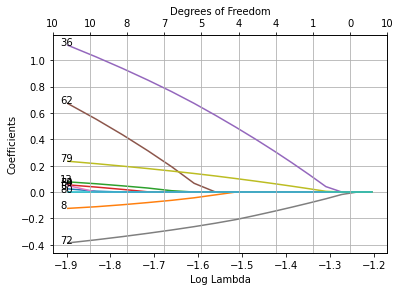

{'fig': <Figure size 432x288 with 2 Axes>,
 'ax1': <AxesSubplot:xlabel='Log Lambda', ylabel='Coefficients'>,
 'ax2': <AxesSubplot:label='6e886ff5-c8e5-453c-bfb6-1121e1a32d11', xlabel='Degrees of Freedom'>}

In [39]:
# Fit a sparse regression to the competition data using glmnet with alpha=1
# ref: https://glmnet-python.readthedocs.io/en/latest/glmnet_vignette.html#Linear-Regression
import glmnet_python
from glmnet import glmnet
from glmnetPrint import glmnetPrint
from glmnetPlot import glmnetPlot

# Define the dataset
data_ar = df_nm1.to_numpy()
label_ar64 = label.to_numpy().astype(np.float64)
# Tune lambda so that you end up with only 10 coefficients that are non-zero.
lambda_list = np.array([0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30])
#lambda_list = np.linspace(0.15,0.30,16)
fit = glmnet(x = data_ar, y = label_ar64, alpha = 1.0, lambdau=lambda_list, nlambda = 20)
# Print out the 10 non-zero coef (df)
print(glmnetPrint(fit))
# Plotting with labels
glmnetPlot(fit, xvar = 'lambda', label = True)


In [40]:
# Print out the non-zero coefficients
from glmnetCoef import glmnetCoef
lambda_10 = 0.15 # Select the lambda value that meets 10 non-zero coefficients
coef_list = glmnetCoef(fit, s = np.float64([lambda_10]), exact = False)
coef_list10 = [i-1 for i in range(len(coef_list)) if coef_list[i] != 0][1:]
print(coef_list10)
# [5, 8, 13, 30, 36, 62, 64, 72, 79, 80]
# 10 variables that those correspond to non-zero coefficients
df_nm1.columns[coef_list10]
# According to the plotting, 'hincome', 'physical_activities_hr_cv' and 'SEX_M' are negatively correlated with stress 
# and rest variables have positively correlation.
# Note that SEX_M and SEX_F are two features after 'SEX' one-hot embedding.
# Conclusion: Female is easier to feel stressed when they realize that their children spend so much time on social media (father doesn't seem to care about this). On the other hand, physical activities help release stress. 
# 小结：（由疫情导致的）家庭不和谐，孩子娱乐时间，女性这三变量与压力成正比（女性压力明显比男性要大）；运动量和收入与压力成反比（明显地，运动越多越能缓解压力）。


[5, 8, 13, 30, 36, 62, 64, 72, 79, 80]


Index(['hisp', 'hincome', 'fam_exp1_cv', 'fam_actions_cv___10',
       'fam_discord_cv', 'child_social_media_time_cv',
       'child_texting_time_2_cv', 'physical_activities_hr_cv', 'SEX_F',
       'SEX_M'],
      dtype='object')

In [42]:
# Make a prediction
from glmnetPredict import glmnetPredict
Y_pred = glmnetPredict(fit, newx = X_test, s=np.float64([lambda_10]))
print("RMSE: {:.4f}.".format(np.sqrt(mean_squared_error(Y_test, Y_pred))))
# The result is pretty bad. Not to submit!


RMSE: 2.8197.


## Neural Networks for Regression

In [43]:
# Implement the neural network for regression 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
# ref: https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/

# Define neural network model
def CNN(n_feat, lr):
    # Implement CNN for regression
    model = Sequential()
    model.add(Dense(32, kernel_initializer='he_normal', activation='relu', input_dim=n_feat))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    # Compile the model and specify loss and optimizer
    opt = SGD(learning_rate=lr, momentum=0.0, nesterov=False)
    model.compile(optimizer=opt, loss='mse')
    return model


In [44]:
# Training the model
X = df_nm1.to_numpy() # train.csv
Y = label.to_numpy()
n_feat = X.shape[1]
lr = 0.01
# Initialize the model
cnn = CNN(n_feat, lr)
# Fit the model on the train data
N_EPOCHS = 50
BATCH_SIZE = 32
cnn.fit(X, Y, epochs=N_EPOCHS, batch_size=BATCH_SIZE, 
        validation_split=0.2, verbose=2)


Train on 6817 samples, validate on 1705 samples
Epoch 1/50
6817/6817 - 2s - loss: 10.7955 - val_loss: 8.4517
Epoch 2/50
6817/6817 - 1s - loss: 8.3682 - val_loss: 8.4537
Epoch 3/50
6817/6817 - 1s - loss: 8.1171 - val_loss: 8.4421
Epoch 4/50
6817/6817 - 1s - loss: 8.0530 - val_loss: 8.4459
Epoch 5/50
6817/6817 - 1s - loss: 8.0444 - val_loss: 8.4416
Epoch 6/50
6817/6817 - 1s - loss: 8.0257 - val_loss: 8.5080
Epoch 7/50
6817/6817 - 1s - loss: 8.0241 - val_loss: 8.4627
Epoch 8/50
6817/6817 - 1s - loss: 8.0249 - val_loss: 8.4434
Epoch 9/50
6817/6817 - 1s - loss: 8.0178 - val_loss: 8.4912
Epoch 10/50
6817/6817 - 1s - loss: 8.0175 - val_loss: 8.4626
Epoch 11/50
6817/6817 - 1s - loss: 8.0188 - val_loss: 8.4500
Epoch 12/50
6817/6817 - 1s - loss: 8.0142 - val_loss: 8.4649
Epoch 13/50
6817/6817 - 1s - loss: 8.0225 - val_loss: 8.4947
Epoch 14/50
6817/6817 - 1s - loss: 8.0143 - val_loss: 8.5213
Epoch 15/50
6817/6817 - 1s - loss: 8.0147 - val_loss: 8.4703
Epoch 16/50
6817/6817 - 1s - loss: 8.0089 - v

In [45]:
# Make predictions on the test set
Y_pred_ = cnn.predict(X_test, verbose=0) # X_te or X_test
# Calculate the average error in the predictions
print("RMSE: {:.4f}.".format(np.sqrt(mean_squared_error(Y_test, Y_pred_))))


RMSE: 3.8576.


In [46]:
# Output the submission
X_te = df_nm2.to_numpy() # test.csv
Y_pred = cnn.predict(X_te, verbose=0)
assert len(Y_pred) != 0
submission_df = pd.DataFrame({'test_id': test_id, 'pstr': Y_pred.flatten()})
submission_df.to_csv('./junzhuang_submission.csv', index=False)
print("Output the submission done!")
# RMSE(test.csv) with dropout=0.3: 2.95444
# RMSE(test.csv) without dropout: 12.49624
# Conlusion: using dropout can largely mitigate the overfitting.


Output the submission done!
